In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from pathlib import Path

---

## Evalutation of EXP4

In [2]:
# Set style for all plots
sns.set_palette("deep")
sns.set_context("talk", font_scale=0.8)


def load_experiment_results(results_dir: str, num_runs: int) -> tuple[list, list]:
    """Load results from multiple experimental runs."""
    results_dir = Path(results_dir)
    challenger_metrics = []
    benchmark_metrics = []

    for run in range(num_runs):
        try:
            # Load challenger results
            challenger_file = results_dir / f"da_challenger_basin_metrics_{run}.csv"
            if challenger_file.exists():
                challenger_metrics.append(pd.read_csv(challenger_file))

            # Load benchmark results
            benchmark_file = results_dir / f"benchmark_basin_metrics_{run}.csv"
            if benchmark_file.exists():
                benchmark_metrics.append(pd.read_csv(benchmark_file))
        except Exception as e:
            print(f"Error loading run {run}: {str(e)}")
            continue

    return challenger_metrics, benchmark_metrics


def aggregate_metrics(metrics_list: list) -> pd.DataFrame:
    """Aggregate metrics across multiple runs."""
    if not metrics_list:
        raise ValueError("No metrics to aggregate")

    # Stack all runs and group by basin_id and horizon
    all_metrics = pd.concat([df.assign(run=i) for i, df in enumerate(metrics_list)])

    # Calculate mean and std across runs
    agg_metrics = (
        all_metrics.groupby(["basin_id", "horizon"])
        .agg(
            {
                "NSE": ["mean", "std"],
                "MSE": ["mean", "std"],
                "MAE": ["mean", "std"],
                "RMSE": ["mean", "std"],
            }
        )
        .reset_index()
    )

    # Flatten column names
    agg_metrics.columns = [
        "_".join(col).strip("_") for col in agg_metrics.columns.values
    ]

    return agg_metrics


def calculate_performance_comparison(
    challenger_df: pd.DataFrame, benchmark_df: pd.DataFrame
) -> pd.DataFrame:
    """Calculate performance comparison between challenger and benchmark models."""
    # Get unique horizons
    horizons = sorted(challenger_df["horizon"].unique())

    results = {
        "horizon": [],
        "better": [],
        "insignificant": [],
        "worse": [],
        "mean_nse_diff": [],
        "std_nse_diff": [],
    }

    for horizon in horizons:
        challenger_horizon = challenger_df[challenger_df["horizon"] == horizon]
        benchmark_horizon = benchmark_df[benchmark_df["horizon"] == horizon]

        comparison = pd.merge(
            challenger_horizon,
            benchmark_horizon,
            on=["basin_id", "horizon"],
            suffixes=("_challenger", "_benchmark"),
        )

        total_basins = len(comparison)

        # Compare mean NSE values
        diff = comparison["NSE_mean_challenger"] - comparison["NSE_mean_benchmark"]

        # Calculate statistical significance using std across runs
        combined_std = np.sqrt(
            comparison["NSE_std_challenger"] ** 2 + comparison["NSE_std_benchmark"] ** 2
        )
        significant_threshold = 1.96 * combined_std  # 95% confidence interval

        # Count significant differences
        challenger_wins = (diff > significant_threshold).sum()
        benchmark_wins = (diff < -significant_threshold).sum()
        insignificant = (abs(diff) <= significant_threshold).sum()

        results["horizon"].append(horizon)
        results["better"].append((challenger_wins / total_basins) * 100)
        results["insignificant"].append((insignificant / total_basins) * 100)
        results["worse"].append((benchmark_wins / total_basins) * 100)
        results["mean_nse_diff"].append(diff.mean())
        results["std_nse_diff"].append(diff.std())

    return pd.DataFrame(results)


def plot_performance_comparison(comparison_df: pd.DataFrame) -> None:
    """Create stacked bar plot of performance comparison."""
    pastel_green = "#6BA292"
    pastel_red = "#93827F"
    pastel_yellow = "#F9E79F"

    plt.figure(figsize=(12, 6))

    plt.bar(
        comparison_df["horizon"],
        comparison_df["better"],
        label="Challenger Significantly Better",
        color=pastel_green,
    )
    plt.bar(
        comparison_df["horizon"],
        comparison_df["insignificant"],
        bottom=comparison_df["better"],
        label="No Significant Difference",
        color=pastel_yellow,
    )
    plt.bar(
        comparison_df["horizon"],
        comparison_df["worse"],
        bottom=comparison_df["better"] + comparison_df["insignificant"],
        label="Benchmark Significantly Better",
        color=pastel_red,
    )

    plt.xlabel("Forecast Horizon (days)")
    plt.ylabel("Percentage of Basins")
    plt.title("Model Performance Comparison by Horizon\nWith Statistical Significance")
    # Add the legend below the plot
    plt.legend(loc="upper center", bbox_to_anchor=(0.5, -0.15), ncol=3)
    plt.ylim(0, 100)

    sns.despine()
    plt.yticks(np.arange(0, 101, 20), [f"{i}%" for i in range(0, 101, 20)])
    plt.xticks(comparison_df["horizon"])

    plt.tight_layout()
    plt.show()


def plot_nse_comparison(
    challenger_df: pd.DataFrame, benchmark_df: pd.DataFrame
) -> None:
    """Create bar plot comparing NSE scores between models."""
    # Calculate mean and confidence intervals for each horizon
    horizons = sorted(challenger_df["horizon"].unique())

    ch_means = [
        challenger_df[challenger_df["horizon"] == h]["NSE_mean"].mean()
        for h in horizons
    ]
    ch_stds = [
        challenger_df[challenger_df["horizon"] == h]["NSE_std"].mean() for h in horizons
    ]

    bm_means = [
        benchmark_df[benchmark_df["horizon"] == h]["NSE_mean"].mean() for h in horizons
    ]
    bm_stds = [
        benchmark_df[benchmark_df["horizon"] == h]["NSE_std"].mean() for h in horizons
    ]

    plt.figure(figsize=(15, 6))
    bar_width = 0.35
    x_pos = np.arange(len(horizons))

    colors = sns.color_palette("Blues", 2)

    # Plot bars with error bars
    plt.bar(
        x_pos - bar_width / 2,
        ch_means,
        bar_width,
        yerr=ch_stds,
        label="Challenger",
        color=colors[0],
        capsize=5,
        alpha=0.8,
    )
    plt.bar(
        x_pos + bar_width / 2,
        bm_means,
        bar_width,
        yerr=bm_stds,
        label="Benchmark",
        color=colors[1],
        capsize=5,
        alpha=0.8,
    )

    plt.xlabel("Forecast Horizon (days)")
    plt.ylabel("Nash-Sutcliffe Efficiency (NSE)")
    plt.title(
        "Model Performance Comparison by Horizon\nwith Standard Deviation across Runs"
    )
    plt.xticks(x_pos, horizons)
    plt.legend()
    sns.despine()

    # Add value labels
    for i, (ch, bm) in enumerate(zip(ch_means, bm_means)):
        plt.text(i - bar_width / 2, ch + 0.02, f"{ch:.2f}", ha="center")
        plt.text(i + bar_width / 2, bm + 0.02, f"{bm:.2f}", ha="center")

    plt.tight_layout()
    plt.show()


def print_summary_statistics(comparison_df: pd.DataFrame) -> None:
    """Print summary statistics of the performance comparison."""
    print("\nPerformance Summary:")
    print(
        f"Average percentage where challenger significantly outperforms: {comparison_df['better'].mean():.1f}%"
    )
    print(
        f"Average percentage with no significant difference: {comparison_df['insignificant'].mean():.1f}%"
    )
    print(
        f"Average percentage where benchmark significantly outperforms: {comparison_df['worse'].mean():.1f}%"
    )

    print(
        f"\nBest horizon for challenger: {comparison_df.loc[comparison_df['better'].idxmax(), 'horizon']} "
        f"({comparison_df['better'].max():.1f}%)"
    )
    print(
        f"Worst horizon for challenger: {comparison_df.loc[comparison_df['better'].idxmin(), 'horizon']} "
        f"({comparison_df['better'].min():.1f}%)"
    )

    mean_nse_improvement = comparison_df["mean_nse_diff"].mean()
    print(f"\nMean NSE improvement across all horizons: {mean_nse_improvement:.3f}")

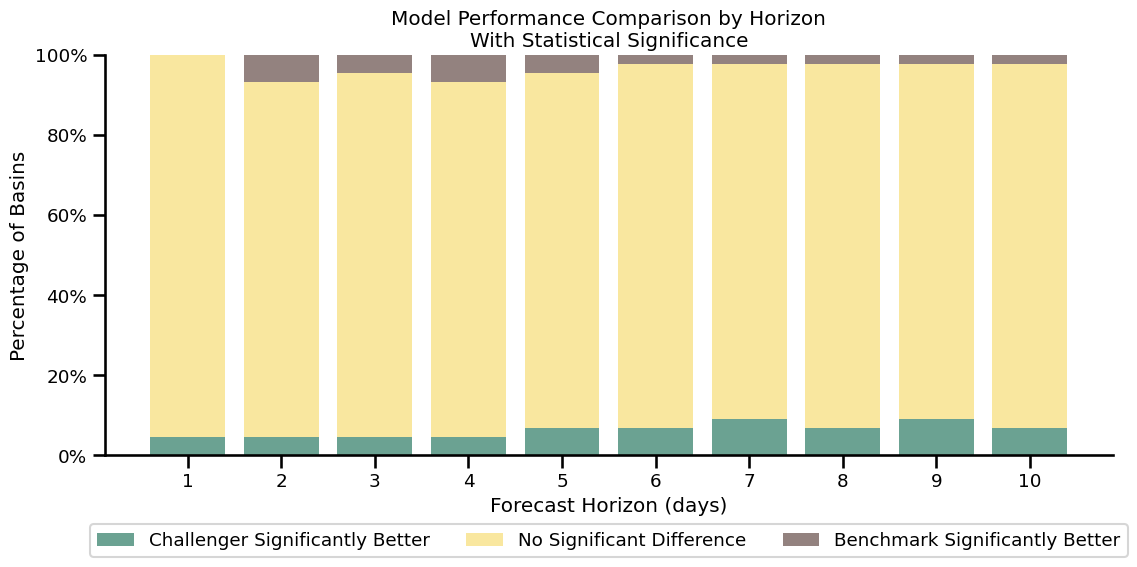

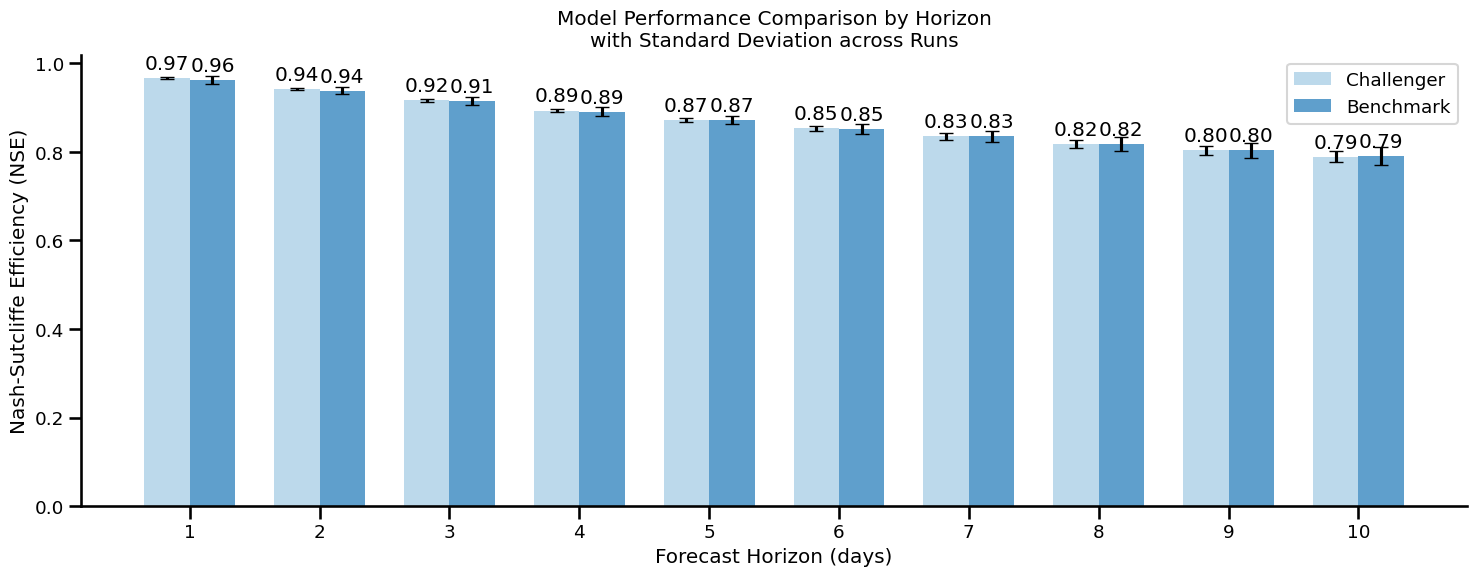


Performance Summary:
Average percentage where challenger significantly outperforms: 6.4%
Average percentage with no significant difference: 90.2%
Average percentage where benchmark significantly outperforms: 3.4%

Best horizon for challenger: 7 (9.1%)
Worst horizon for challenger: 1 (4.5%)

Mean NSE improvement across all horizons: 0.001


In [3]:
# Main execution
results_dir = "/Users/cooper/Desktop/CAMELS-CH/experiments/AdversarialDomainAdaptation/results"
num_runs = 3  # Update with your number of runs

# Load and process results
challenger_metrics_list, benchmark_metrics_list = load_experiment_results(
    results_dir, num_runs)

# Aggregate metrics across runs
challenger_agg = aggregate_metrics(challenger_metrics_list)
benchmark_agg = aggregate_metrics(benchmark_metrics_list)

# Calculate and visualize performance comparison
comparison_df = calculate_performance_comparison(challenger_agg, benchmark_agg)
plot_performance_comparison(comparison_df)
plot_nse_comparison(challenger_agg, benchmark_agg)
print_summary_statistics(comparison_df)